# Final Project: WikiArt Classification Tasks
## CSC 594: Advanced Deep Learning
## Ross Pollock

In [1]:
import tensorflow as tf
import tensorflow.keras as keras 
import tensorflow.keras.layers as L

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler


from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Move and extract dataset

In [2]:
! tar xfz /drive/My\ Drive/CSC594/Data/Image/wikiart.tar.gz -C /content/

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.

## Helper Functions

In [3]:
def plot_training_history(
    history: keras.callbacks.History
) -> None: 
  n_epochs = len(history.history['val_loss'])
  fig, axs = plt.subplots(ncols=2,figsize=(16,8))

  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['val_accuracy'],
      ax=axs[0],label='Validation'
  )
  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['accuracy'],
      ax=axs[0],label='Training'
  )

  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['val_loss'],
      ax=axs[1],label='Validation'
  )
  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['loss'],
      ax=axs[1],label='Training'
  ) 
  

  axs[0].set_title('Model Accuracy')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')
  axs[1].set_title('Model Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')

  plt.suptitle('Model Training')
  plt.show()



In [4]:
@tf.function
def smart_resize(img,size=244):
  h,w = tf.shape(img)[0], tf.shape(img)[1]
  min_dim = tf.minimum(h,w)
  ratio = size / tf.cast(min_dim,tf.float32) 

  new_w = tf.cast(w,tf.float32) * ratio
  new_h = tf.cast(h,tf.float32) * ratio

  img = tf.image.resize(img,[new_h,new_w],preserve_aspect_ratio=True)
  img = tf.image.resize_with_crop_or_pad(img,size,size)
  return img

@tf.function
def img_preprocess(fpath):
    img = tf.io.read_file(fpath)
    img = tf.image.decode_jpeg(img,3)
    img = tf.cast(img,tf.float32)
    img = smart_resize(img,size=244)
    img /= (255/2)
    img -= 1 
    return img 

In [5]:
def load_img(fpath):
  img = tf.io.read_file(fpath)
  img = tf.image.decode_jpeg(img,3)
  img = tf.image.resize_with_crop_or_pad(img,244,244)
  return img 

In [6]:
def GradCAM(
    feature_extractor,classifier,
    image_path,label_encoder,
    true_label=None,cmap='jet',
    **kwargs):
  
  # Load Original and Preprocessed Image
  original_image = load_img(image_path)
  preprocessed_image = img_preprocess(image_path)
  preprocessed_image = tf.expand_dims(preprocessed_image,0)

  # 
  last_conv_name = feature_extractor.layers[-2].name
  last_conv_layer = feature_extractor.get_layer(last_conv_name)
  last_covn_model = keras.Model(feature_extractor.inputs,last_conv_layer.output)


  clf_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = clf_input
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = classifier(x)
  clf_model = keras.Model(clf_input,x)

  with tf.GradientTape() as tape:
    last_conv_model_out = last_covn_model(preprocessed_image)
    tape.watch(last_conv_model_out)
    preds = clf_model(last_conv_model_out)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

  predicted_label = label_encoder.inverse_transform( np.expand_dims(top_pred_idx.numpy(),0) )[0]

  grads = tape.gradient(top_class_channel,last_conv_model_out)
  pooled_grads = tf.reduce_mean(grads,axis=[0,1,2])
  last_conv_model_out = last_conv_model_out.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    last_conv_model_out[:,:,i] *= pooled_grads[i]

  heatmap = np.mean(last_conv_model_out,axis=-1)
  heatmap = np.maximum(heatmap,0) / np.max(heatmap)

  heatmap = np.uint8(255*heatmap)
  jet = cm.get_cmap('jet')
  jet_colors = jet(np.arange(256))[:,:3]
  jet_heatmap = jet_colors[heatmap]
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((original_image.shape[1], original_image.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  #superimposed_img = jet_heatmap * 0.4 + original_image
  #superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


  # Show Explaination
  fig, axs = plt.subplots(ncols=3,**kwargs)
  fig.suptitle(f'True Label: {true_label} \nPredicted Label: {predicted_label}')
  axs[0].imshow(original_image)
  axs[0].set_yticks([])
  axs[0].set_xticks([])
  axs[0].set_xlabel('Original Image')

  axs[1].imshow(jet_heatmap.astype(np.uint8))
  axs[1].set_yticks([])
  axs[1].set_xticks([])
  axs[1].set_xlabel('Attention Map')

  axs[2].imshow(original_image)
  axs[2].imshow(jet_heatmap.astype(np.uint8),alpha=0.4,cmap='jet')
  axs[2].set_yticks([])
  axs[2].set_xticks([])
  axs[2].set_xlabel('Overlayer')
  plt.tight_layout()
  plt.show()

## Load Metadata

In [7]:
wikiart = pd.read_csv('/drive/My Drive/CSC594/Data/wikiart_labels.csv')

wikiart_train = wikiart[wikiart.train == 1]
wikiart_test  = wikiart[wikiart.train == 0]
wikiart_train_paths = wikiart_train.relative_path.to_list()
wikiart_train_paths = list(map(lambda x: '/content/wikiart_reduced/' + x,wikiart_train_paths))

wikiart_test_paths = wikiart_test.relative_path.to_list()
wikiart_test_paths = list(map(lambda x: '/content/wikiart_reduced/' + x,wikiart_test_paths))

wikiart_train_labels = wikiart_train.art_style.to_numpy()
wikiart_test_labels = wikiart_test.art_style.to_numpy()

n_train = len(wikiart_train_paths)
n_test = len(wikiart_test_paths)

### Encode Labels

In [8]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(wikiart_train_labels) 
y_test  = label_encoder.transform(wikiart_test_labels)

### Generate TF Dataset 

In [9]:
BATCH_SIZE = 128
ds_train = tf.data.Dataset.from_tensor_slices(wikiart_train_paths)
ds_train = ds_train.map(img_preprocess)
ds_train = ds_train.batch(BATCH_SIZE)

ds_test = tf.data.Dataset.from_tensor_slices(wikiart_test_paths)
ds_test = ds_test.map(img_preprocess)
ds_test = ds_test.batch(BATCH_SIZE)

### Load Pre-trained Model

In [10]:
class ResNetBlock(L.Layer):
  def __init__(self,n_filters,regularizer=keras.regularizers.L2(1e-3),activation=L.ReLU,start=False,downsample=False):
    super(ResNetBlock,self).__init__()
    self.regularizer = regularizer
    self.activation = activation
    self.n_filters = n_filters
    self.start = start
    self.stride = 2 if downsample else 1


    self.left_path = keras.Sequential(
        [
          L.Conv2D(self.n_filters,1,self.stride,padding='same',kernel_regularizer=self.regularizer),
          L.BatchNormalization(),
          self.activation(),
          L.Conv2D(self.n_filters,3,1,padding='same',kernel_regularizer=self.regularizer),
          L.BatchNormalization(),
          self.activation(),
          L.Conv2D(self.n_filters*4,1,1,padding='same',kernel_regularizer=self.regularizer),
          L.BatchNormalization()
        ]
    )
  

    
    if self.start:
      self.right_path = keras.Sequential(
          [
           L.Conv2D(self.n_filters*4,1,self.stride,'same',kernel_regularizer=self.regularizer),
           L.BatchNormalization()
          ]
      )

    

  def call(self,input_tensor,training=False):
    x = self.left_path(input_tensor)
    if self.start:
      y = self.right_path(input_tensor)
    else:
      y = input_tensor

    z = tf.add(x,y)
    return self.activation()(z)
      


class ResNetStack(L.Layer):
  def __init__(self,n_blocks,n_filters,first_block=False,**kwargs):
    super(ResNetStack,self).__init__()
    blocks = [ ResNetBlock(n_filters,start=(not i),downsample=(not i and not first_block),**kwargs) for i in range(n_blocks)]
    self.stack = keras.Sequential(
        blocks
    )
    self.out_dim = n_filters * 4

  def call(self,input_tensor,training=False):

    return self.stack(input_tensor) 

def ResNet(n_layers,width=1,input_shape=None,**kwargs):
    if n_layers not in [50,101,152]:
      raise ValueError
    
    model = keras.Sequential([
        L.Input(input_shape),
        L.Conv2D(64,7,2,padding='same'),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(3,2,'same')
        
    ],name=f'ResNet{n_layers}')

    model_specs = {
        50: [3,4,6,3],
        101: [3,4,23,3],
        152: [3,8,36,3]
    }
    filters = list(map(lambda x: x*width,[64,128,256,512]))

    for i,(stack,f) in enumerate(zip(model_specs[n_layers],filters)):
      if i == 0:
        stack = ResNetStack(stack,f,first_block=True)
      else:
        stack = ResNetStack(stack,f,first_block=False)
      model.add(stack)
    model.add(L.GlobalAveragePooling2D())
    return model

In [11]:
# Download and extract model
model_url = 'https://rosspollock.design/models/resnet50120.tar.gz'
keras.utils.get_file('model2',model_url,untar=True,extract=True)
encoder = keras.models.load_model('/root/.keras/datasets/query_encoder120k')
cnn_name = encoder.layers[0].name
encoder = encoder.get_layer(cnn_name)
if encoder.name == 'ResNet50':
  new_encoder = ResNet(50,2,input_shape=(244,244,3))
  new_encoder.set_weights(encoder.get_weights())
  encoder = new_encoder 
  del new_encoder
_, rep_dim = encoder.output_shape

103489536/103482239 [==============================] - 7s 0us/step


### Extract Representations from Model

In [12]:
x_train = np.zeros((n_train,rep_dim))
x_test = np.zeros((n_test,rep_dim))


pbar = keras.utils.Progbar(n_train // BATCH_SIZE + 1 )
for i, batch in enumerate(ds_train):
  reps = encoder(batch,training=False)
  x_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = reps.numpy()
  pbar.update(i+1)

pbar = keras.utils.Progbar(n_test // BATCH_SIZE + 1 )
for i, batch in enumerate(ds_test):
  reps = encoder(batch,training=False)
  x_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:] = reps.numpy()
  pbar.update(i+1)

128/128 [==============================] - 94s 734ms/step


### Scale The Representation

In [13]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Build Softmax Classifier

In [14]:
softmax_clf = keras.Sequential([
  keras.layers.Input(shape=(rep_dim,)),
  keras.layers.Dense(27,'softmax')
])
softmax_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 27)                55323     
Total params: 55,323
Trainable params: 55,323
Non-trainable params: 0
_________________________________________________________________


### Train Classifier on Learned Representations

In [15]:
from sklearn.utils import class_weight
 

In [16]:
softmax_clf.compile(
    keras.optimizers.Adam(1e-3),
    keras.losses.SparseCategoricalCrossentropy(),
    'accuracy'
)

In [17]:
history = softmax_clf.fit(x_train_scaled,y_train,epochs=50,validation_split=0.2,verbose=1)

Epoch 1/50
1629/1629 [==============================] - 6s 3ms/step - loss: 2.1928 - accuracy: 0.3568 - val_loss: 1.9898 - val_accuracy: 0.3913
Epoch 2/50
1629/1629 [==============================] - 4s 2ms/step - loss: 1.9385 - accuracy: 0.3977 - val_loss: 1.9113 - val_accuracy: 0.4048
Epoch 3/50
1629/1629 [==============================] - 4s 2ms/step - loss: 1.8732 - accuracy: 0.4086 - val_loss: 1.8786 - val_accuracy: 0.4085
Epoch 4/50
1629/1629 [==============================] - 4s 2ms/step - loss: 1.8408 - accuracy: 0.4116 - val_loss: 1.8707 - val_accuracy: 0.4069
Epoch 5/50
1629/1629 [==============================] - 4s 2ms/step - loss: 1.8197 - accuracy: 0.4191 - val_loss: 1.8545 - val_accuracy: 0.4128
Epoch 6/50
1629/1629 [==============================] - 4s 2ms/step - loss: 1.8040 - accuracy: 0.4183 - val_loss: 1.8461 - val_accuracy: 0.4177
Epoch 7/50
1629/1629 [==============================] - 4s 2ms/step - loss: 1.7929 - accuracy: 0.4222 - val_loss: 1.8477 - val_accuracy:

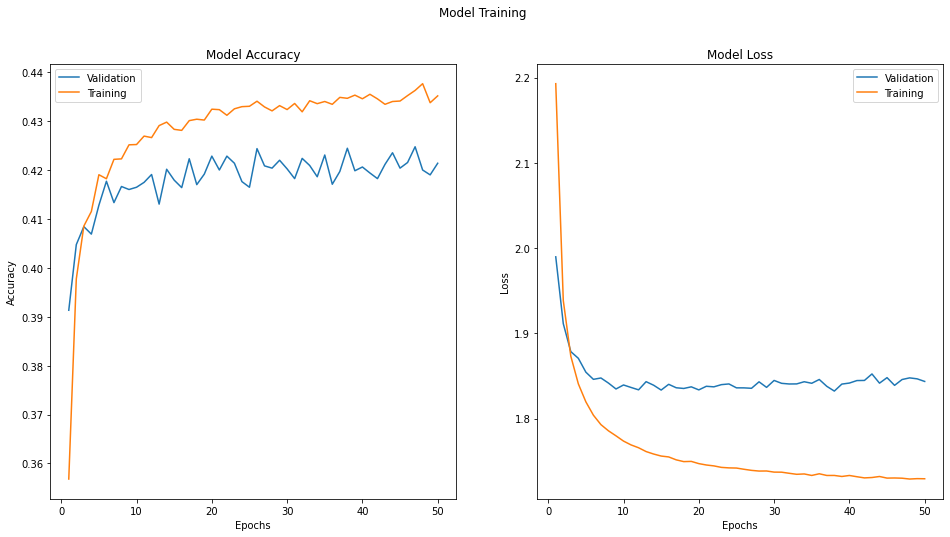

In [18]:
plot_training_history(history)

### Evaluate On With-held test set

In [19]:
test_loss, test_acc = softmax_clf.evaluate(x_test_scaled,y_test,verbose=0)
print(f'Test Accuracy: {100*test_acc:0.2f}')

Test Accuracy: 41.89


### Explaination 

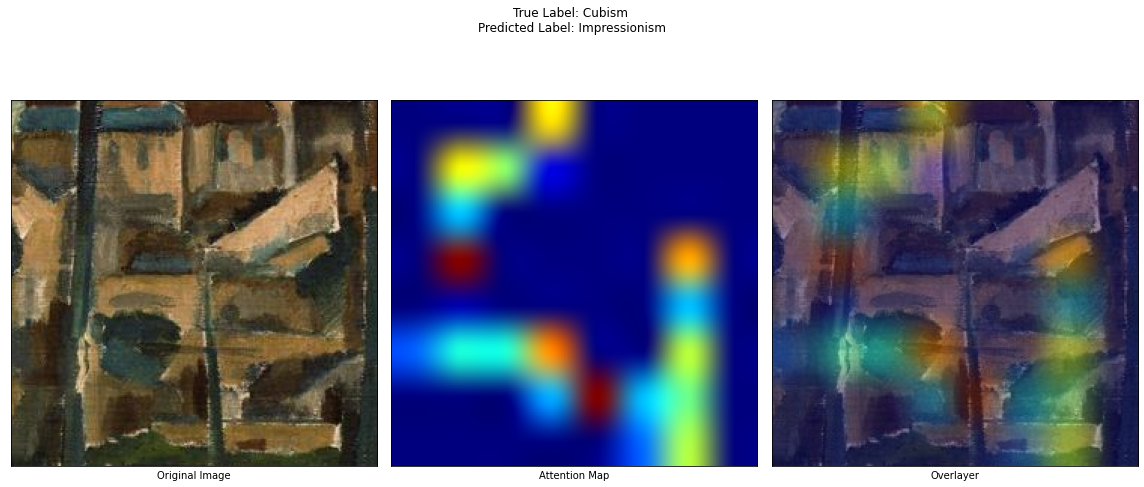

In [20]:
idx = np.random.choice(wikiart_train_labels.shape[0],1)
image_path = wikiart_train_paths[idx[0]]
image_path = tf.constant(image_path)
true_label = wikiart_train_labels[idx][0]
GradCAM(encoder,softmax_clf,image_path,label_encoder,true_label,figsize=(16,8))

# Artist Recognition

In [21]:
wikiartist = wikiart.groupby('artist_name').filter(lambda x: x['train'].count() > 500)

In [22]:
wikiartist_train_paths = wikiartist.relative_path.to_list()
wikiartist_train_paths = list(map(lambda x: '/content/wikiart_reduced/' + x,wikiartist_train_paths))

In [23]:
artist_train_idx = wikiartist[wikiartist['train'] == 1].index
artist_test_idx = wikiartist[wikiartist['train'] == 0].index

In [24]:
artist_train = wikiartist[wikiartist['train'] == 1].artist_name
artist_test = wikiartist[wikiartist['train'] == 0].artist_name

In [25]:
artist_encoder = LabelEncoder()
artist_encoder.fit(wikiartist.artist_name.unique())
artist_train = artist_encoder.transform(artist_train)
artist_test = artist_encoder.transform(artist_test)

In [26]:
n_artists = wikiartist.groupby('artist_name').count().shape[0]
print(f'Number of Artists: {n_artists}')

Number of Artists: 23


In [27]:
softmax_clf = keras.Sequential([
  keras.layers.Input(shape=(rep_dim,)),
  keras.layers.Dense(n_artists,'softmax',)
])
softmax_clf.summary()

softmax_clf.compile(
    keras.optimizers.Adam(),
    keras.losses.SparseCategoricalCrossentropy(),
    ['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 23)                47127     
Total params: 47,127
Trainable params: 47,127
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = softmax_clf.fit(x_train_scaled[artist_train_idx],artist_train,256,epochs=50,validation_split=0.2,verbose=2)

Epoch 1/50
49/49 - 1s - loss: 2.4359 - accuracy: 0.3206 - sparse_top_k_categorical_accuracy: 0.6713 - val_loss: 1.9321 - val_accuracy: 0.4683 - val_sparse_top_k_categorical_accuracy: 0.8144
Epoch 2/50
49/49 - 0s - loss: 1.7503 - accuracy: 0.5169 - sparse_top_k_categorical_accuracy: 0.8365 - val_loss: 1.6425 - val_accuracy: 0.5420 - val_sparse_top_k_categorical_accuracy: 0.8516
Epoch 3/50
49/49 - 0s - loss: 1.5406 - accuracy: 0.5689 - sparse_top_k_categorical_accuracy: 0.8679 - val_loss: 1.5166 - val_accuracy: 0.5660 - val_sparse_top_k_categorical_accuracy: 0.8674
Epoch 4/50
49/49 - 0s - loss: 1.4292 - accuracy: 0.5932 - sparse_top_k_categorical_accuracy: 0.8854 - val_loss: 1.4437 - val_accuracy: 0.5873 - val_sparse_top_k_categorical_accuracy: 0.8777
Epoch 5/50
49/49 - 0s - loss: 1.3558 - accuracy: 0.6145 - sparse_top_k_categorical_accuracy: 0.8953 - val_loss: 1.3950 - val_accuracy: 0.5993 - val_sparse_top_k_categorical_accuracy: 0.8871
Epoch 6/50
49/49 - 0s - loss: 1.3031 - accuracy: 0

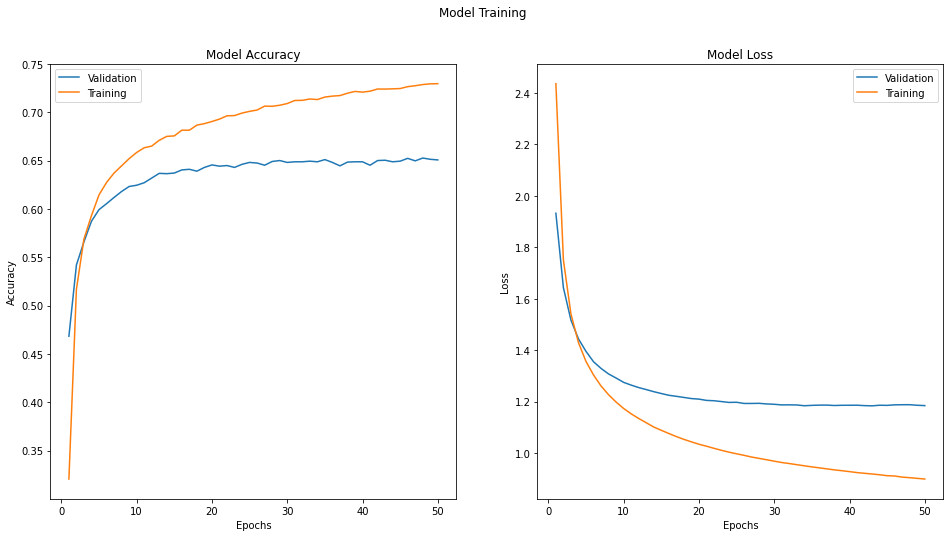

In [29]:
plot_training_history(history)

In [30]:
test_loss, test_acc, test_top_5 = softmax_clf.evaluate(x_test_scaled[artist_test_idx - x_train_scaled.shape[0]],artist_test,verbose=0)
print(f'Test Accuracy: {100*test_acc:0.2f}')
print(f'Top-5 Accuracy: {100*test_top_5:0.2f}')

Test Accuracy: 65.97
Top-5 Accuracy: 91.29


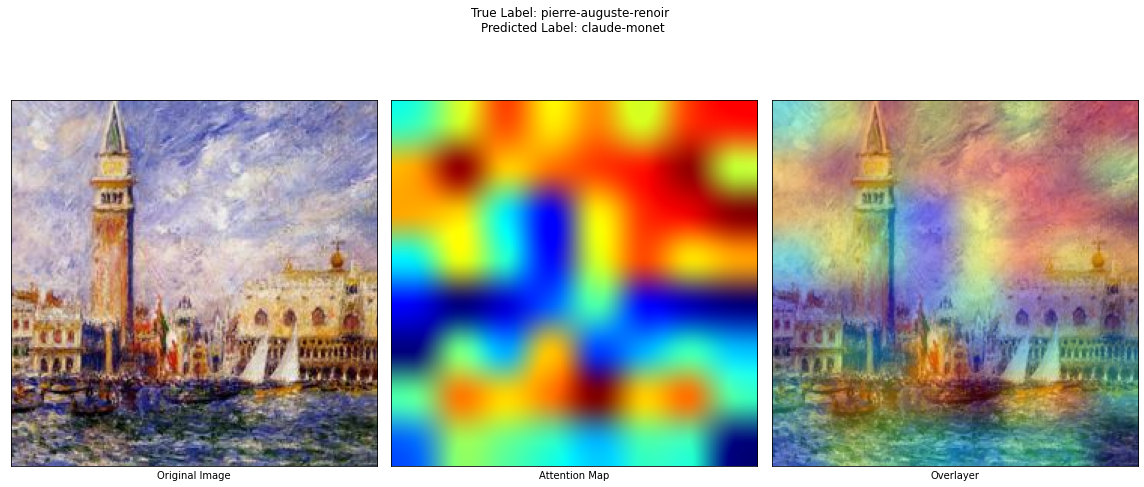

In [31]:
idx = np.random.choice(x_train_scaled[artist_train_idx].shape[0],1)
image_path = wikiartist_train_paths[idx[0]]
image_path = tf.constant(image_path)
true_label = artist_encoder.inverse_transform(artist_train[idx])[0]
GradCAM(encoder,softmax_clf,image_path,artist_encoder,true_label,figsize=(16,8))

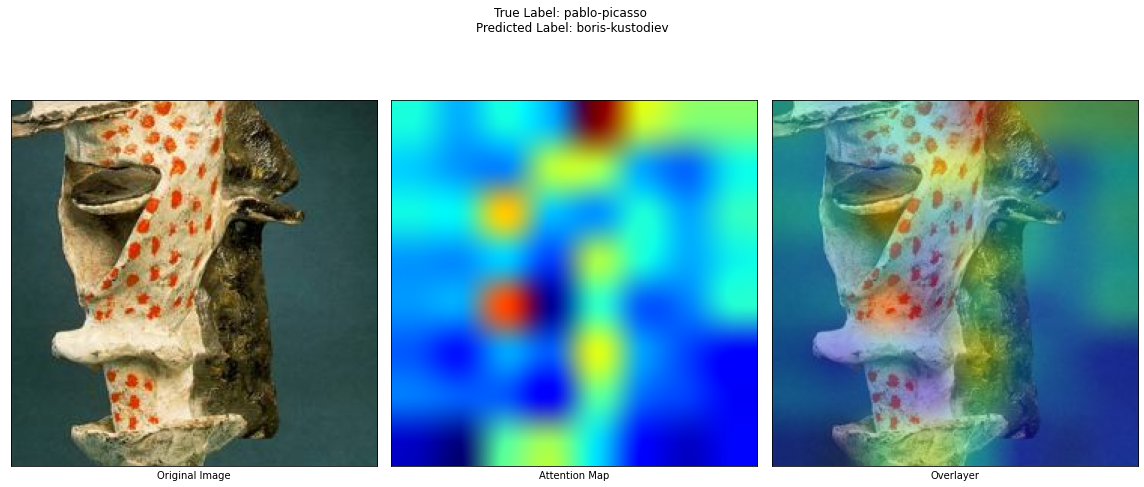

In [32]:
idx = np.random.choice(x_train_scaled[artist_train_idx].shape[0],1)
image_path = wikiartist_train_paths[idx[0]]
image_path = tf.constant(image_path)
true_label = artist_encoder.inverse_transform(artist_train[idx])[0]
GradCAM(encoder,softmax_clf,image_path,artist_encoder,true_label,figsize=(16,8))

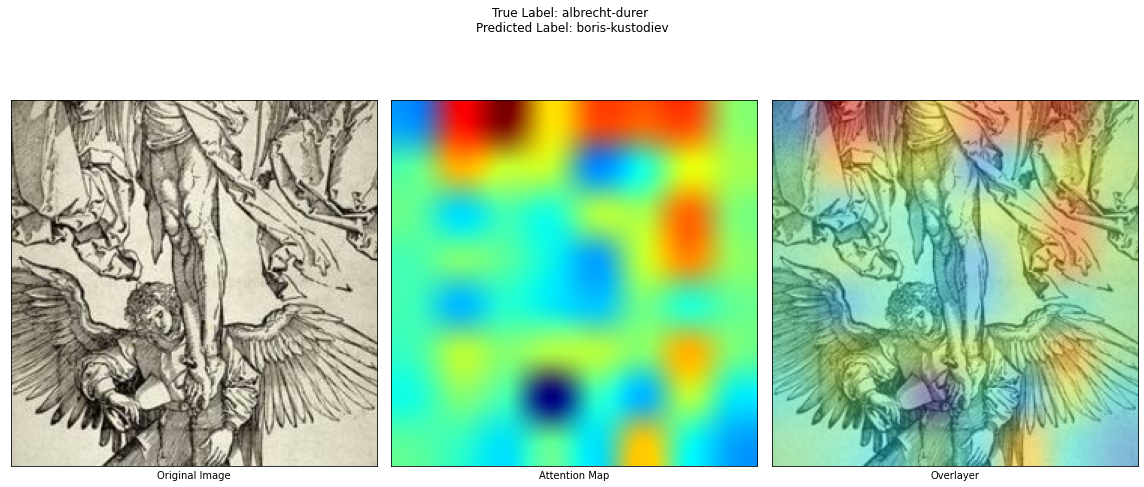

In [33]:
idx = np.random.choice(x_train_scaled[artist_train_idx].shape[0],1)
image_path = wikiartist_train_paths[idx[0]]
image_path = tf.constant(image_path)
true_label = artist_encoder.inverse_transform(artist_train[idx])[0]
GradCAM(encoder,softmax_clf,image_path,artist_encoder,true_label,figsize=(16,8))

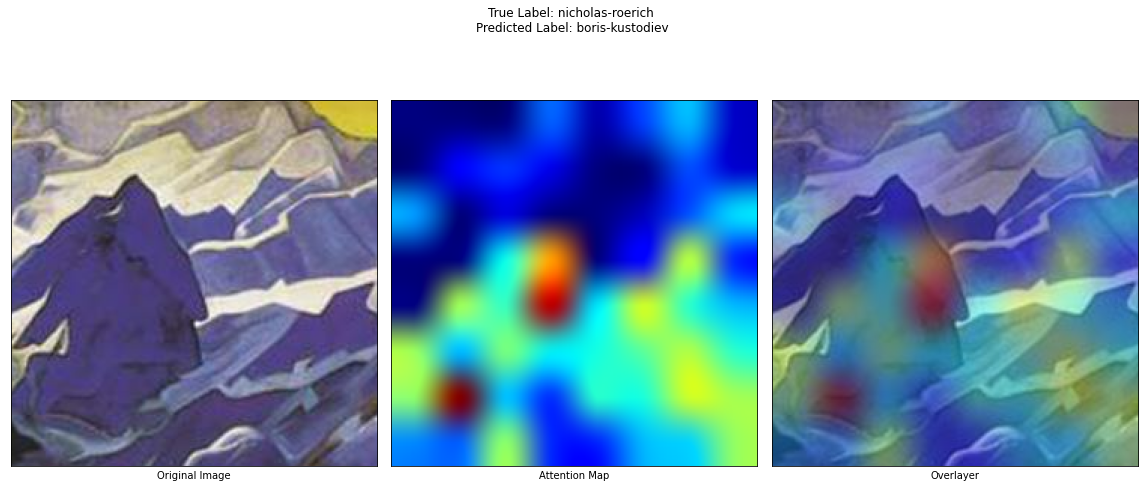

In [34]:
idx = np.random.choice(x_train_scaled[artist_train_idx].shape[0],1)
image_path = wikiartist_train_paths[idx[0]]
image_path = tf.constant(image_path)
true_label = artist_encoder.inverse_transform(artist_train[idx])[0]
GradCAM(encoder,softmax_clf,image_path,artist_encoder,true_label,figsize=(16,8))

## Artist Recognition

Number of Artists: 83
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 83)                170067    
Total params: 170,067
Trainable params: 170,067
Non-trainable params: 0
_________________________________________________________________


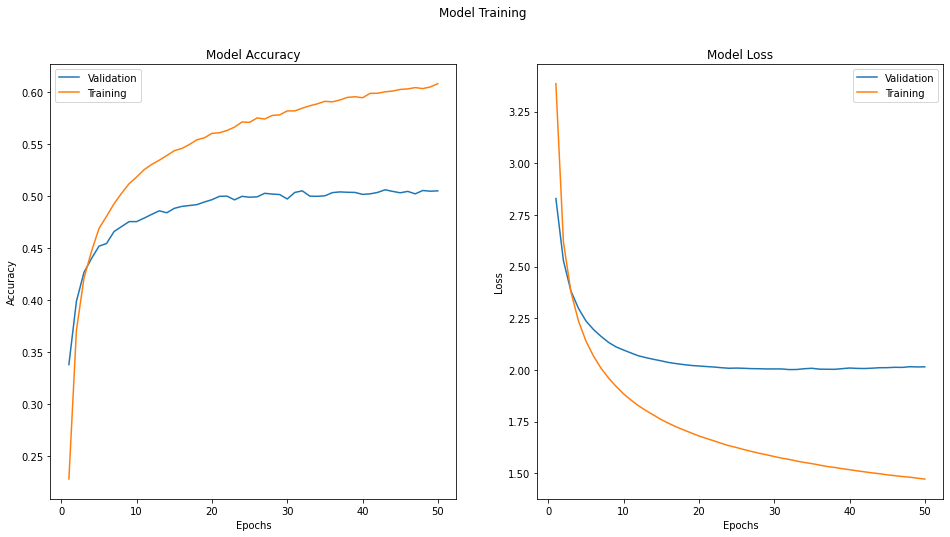

Test Accuracy: 50.39
Top-5 Accuracy: 77.29


In [35]:
wikiartist = wikiart.groupby('artist_name').filter(lambda x: x['train'].count() > 200)

wikiartist_train_paths = wikiartist.relative_path.to_list()
wikiartist_train_paths = list(map(lambda x: '/content/wikiart_reduced/' + x,wikiartist_train_paths))

artist_train_idx = wikiartist[wikiartist['train'] == 1].index
artist_test_idx = wikiartist[wikiartist['train'] == 0].index

artist_train = wikiartist[wikiartist['train'] == 1].artist_name
artist_test = wikiartist[wikiartist['train'] == 0].artist_name

artist_encoder = LabelEncoder()
artist_encoder.fit(wikiartist.artist_name.unique())
artist_train = artist_encoder.transform(artist_train)
artist_test = artist_encoder.transform(artist_test)

n_artists = wikiartist.groupby('artist_name').count().shape[0]
print(f'Number of Artists: {n_artists}')

softmax_clf = keras.Sequential([
  keras.layers.Input(shape=(rep_dim,)),
  keras.layers.Dense(n_artists,'softmax',)
])
softmax_clf.summary()

softmax_clf.compile(
    keras.optimizers.Adam(),
    keras.losses.SparseCategoricalCrossentropy(),
    ['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
)

history = softmax_clf.fit(x_train_scaled[artist_train_idx],artist_train,256,epochs=50,validation_split=0.2,verbose=0)
plot_training_history(history)

test_loss, test_acc, test_top_5 = softmax_clf.evaluate(x_test_scaled[artist_test_idx - x_train_scaled.shape[0]],artist_test,verbose=0)
print(f'Test Accuracy: {100*test_acc:0.2f}')
print(f'Top-5 Accuracy: {100*test_top_5:0.2f}')

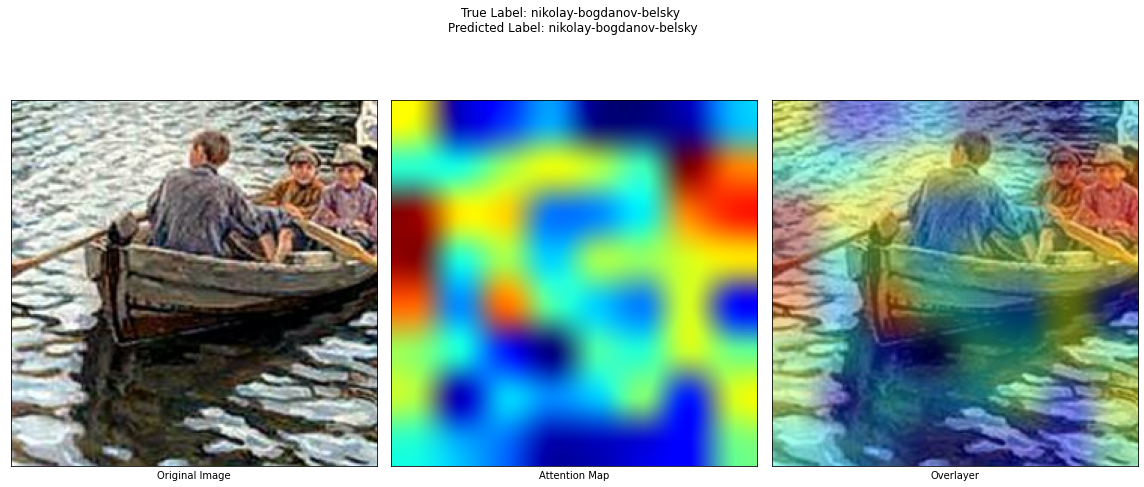

In [36]:
idx = np.random.choice(x_train_scaled[artist_train_idx].shape[0],1)
image_path = wikiartist_train_paths[idx[0]]
image_path = tf.constant(image_path)
true_label = artist_encoder.inverse_transform(artist_train[idx])[0]
GradCAM(encoder,softmax_clf,image_path,artist_encoder,true_label,figsize=(16,8))